# The Sparks Foundation -Data Science and Business Anaylytics

## Task-7: Stock Market Prediction using Numerical and Textual Analysis

### Create a hybrid model for stock price/performanceprediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines


In [ ]:
import warnings
warnings.filterwarnings('ignore')


import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler






In [31]:
# reading the datasets into pandas
stock_price = pd.read_csv('^BSESN.csv')
stock_price

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0
...,...,...,...,...,...,...,...
3677,2019-11-25,40439.660156,40931.710938,40393.898438,40889.230469,40889.230469,28600.0
3678,2019-11-26,41022.851563,41120.281250,40710.199219,40821.300781,40821.300781,32800.0
3679,2019-11-27,40979.390625,41075.761719,40848.699219,41020.609375,41020.609375,32400.0
3680,2019-11-28,41161.539063,41163.789063,40996.078125,41130.171875,41130.171875,30900.0


In [32]:
stock_headlines = pd.read_csv('india-news-headlines.csv')
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [33]:
len(stock_price),len(stock_headlines)

(3682, 3424067)

In [34]:
stock_price.isna().any(), stock_headlines.isna().any()


(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [35]:
stock_price.dropna(axis=0, inplace=True)


In [36]:
# dropping duplicates in data
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0
...,...,...,...,...,...
2019-11-25,40889.230469,40439.660156,40931.710938,40393.898438,28600.0
2019-11-26,40821.300781,41022.851563,41120.281250,40710.199219,32800.0
2019-11-27,41020.609375,40979.390625,41075.761719,40848.699219,32400.0


In [37]:
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [38]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0,"ICAI compliments minister,Partnering for futur..."
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S..."
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0,"Quake Rumours,Mishap reunites 12-yr boy with f..."
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0,"Doon School preparing to admit girls?,Market M..."
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0,"Faultline Repair,No Parade; Please,NRI Spirit,..."
...,...,...,...,...,...,...
2019-11-25,40889.230469,40439.660156,40931.710938,40393.898438,28600.0,Micro review: 'The Night Fire' by Michael Conn...
2019-11-26,40821.300781,41022.851563,41120.281250,40710.199219,32800.0,Indore's fairs and festivities will be promote...
2019-11-27,41020.609375,40979.390625,41075.761719,40848.699219,32400.0,Kanpur: 'Tyre puncture' gang robs retired Army...
2019-11-28,41130.171875,41161.539063,41163.789063,40996.078125,30900.0,Housing for 1;800 families: SC panel calls for...


In [39]:
#Sentiment Analysis
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0,"ICAI compliments minister,Partnering for futur...",,,,
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S...",,,,
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0,"Quake Rumours,Mishap reunites 12-yr boy with f...",,,,
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0,"Doon School preparing to admit girls?,Market M...",,,,
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0,"Faultline Repair,No Parade; Please,NRI Spirit,...",,,,


In [40]:
# dropping unwanted 'headline_text' and rearranging columns
stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-03,6679.200195,,,,,6626.490234,6684.220215,6626.490234,12000.0
2005-01-04,6651.009766,,,,,6683.560059,6696.310059,6640.899902,16600.0
2005-01-05,6458.839844,,,,,6628.890137,6629.979980,6337.609863,24000.0
2005-01-06,6367.390137,,,,,6447.270020,6481.229980,6325.359863,22200.0
2005-01-07,6420.459961,,,,,6374.189941,6440.169922,6348.750000,17800.0


In [41]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [42]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,3655.000000,3655,3655,3655,3655,3655.000000,3655.000000,3655.000000,3.655000e+03
unique,NaN,1,1,1,1,NaN,NaN,NaN,NaN
top,NaN,,,,,NaN,NaN,NaN,NaN
freq,NaN,3655,3655,3655,3655,NaN,NaN,NaN,NaN
mean,21124.125256,NaN,NaN,NaN,NaN,21146.347264,21269.132682,20984.649405,1.037558e+05
std,8733.757649,NaN,NaN,NaN,NaN,8749.525123,8759.377962,8716.504502,1.237143e+06
min,6102.740234,NaN,NaN,NaN,NaN,6093.660156,6174.000000,6069.330078,8.000000e+02
25%,15149.320312,NaN,NaN,NaN,NaN,15181.980469,15328.830078,15007.475098,1.060000e+04
50%,19016.460938,NaN,NaN,NaN,NaN,19072.019531,19201.919922,18864.810547,1.420000e+04
75%,27579.464844,NaN,NaN,NaN,NaN,27634.455078,27772.924805,27438.979493,2.000000e+04


Text(0, 0.5, 'Close Price (INR)')

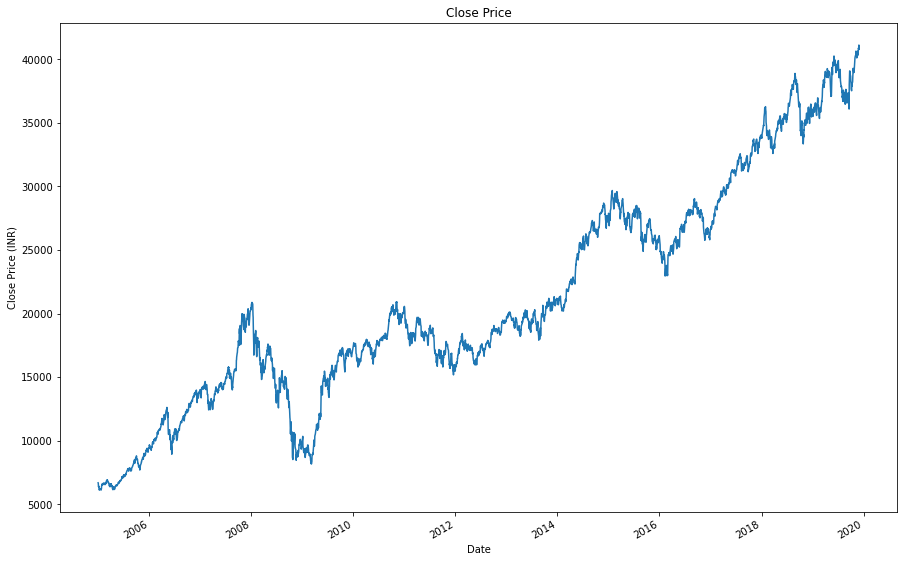

In [43]:
#Setting plot size and labels
plt.figure(figsize=(15,10))

stock_data['Close'].plot()


plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [44]:

# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,Open,High,Low,Volume
2005-01-03,NaN,NaN,NaN,NaN,NaN
2005-01-04,NaN,NaN,NaN,NaN,NaN
2005-01-05,NaN,NaN,NaN,NaN,NaN
2005-01-06,NaN,NaN,NaN,NaN,NaN
2005-01-07,NaN,NaN,NaN,NaN,NaN
2005-01-10,NaN,NaN,NaN,NaN,NaN
2005-01-11,6444.044294,6502.588658,6532.984305,6396.397112,17428.571429
2005-01-12,6361.692871,6448.854353,6472.911412,6316.945661,18685.714286
2005-01-13,6300.271484,6370.924317,6408.145717,6245.109933,19200.000000
2005-01-14,6259.554339,6314.285714,6353.775739,6217.462821,18371.428571


<AxesSubplot:>

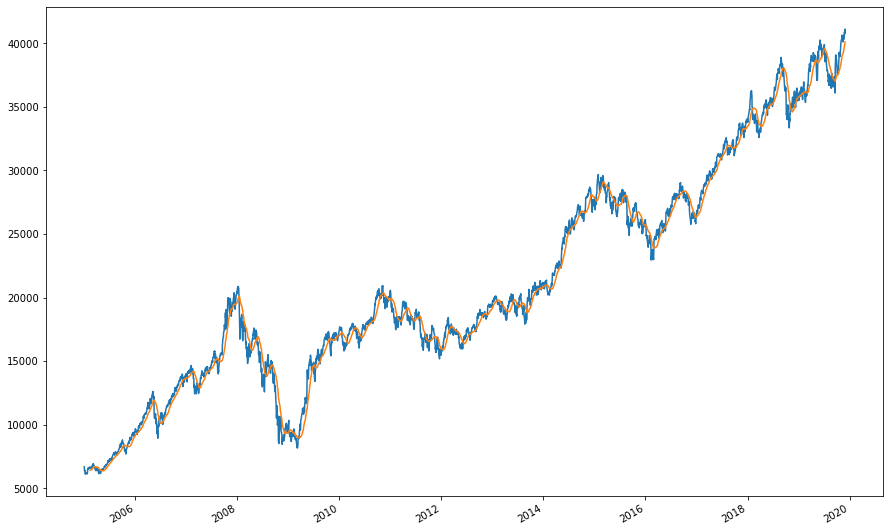

In [45]:
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [46]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 2923
Number of records in Test Data: 732


In [47]:
# predicting one step ahead
steps_to_predict = 1


close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2005-01-04     6651.009766
2005-01-05     6458.839844
2005-01-06     6367.390137
2005-01-07     6420.459961
2005-01-10     6308.540039
                  ...     
2019-11-25    40889.230469
2019-11-26    40821.300781
2019-11-27    41020.609375
2019-11-28    41130.171875
2019-11-29    40793.808594
Name: Close, Length: 3654, dtype: float64

In [48]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2005-01-04,6651.009766,6458.839844,,,16600.0,6683.560059,6696.310059,6640.899902
2005-01-05,6458.839844,6367.390137,,,24000.0,6628.890137,6629.979980,6337.609863
2005-01-06,6367.390137,6420.459961,,,22200.0,6447.270020,6481.229980,6325.359863
2005-01-07,6420.459961,6308.540039,,,17800.0,6374.189941,6440.169922,6348.750000
2005-01-10,6308.540039,6222.870117,,,13200.0,6440.330078,6469.089844,6286.850098
2005-01-11,6222.870117,6102.740234,,,16200.0,6317.390137,6329.890137,6208.819824
2005-01-12,6102.740234,6221.060059,,,20800.0,6250.350098,6263.709961,6070.330078
2005-01-13,6221.060059,6173.819824,,,20200.0,6138.049805,6242.950195,6138.049805
2005-01-14,6173.819824,6194.069824,,,18200.0,6232.419922,6249.390137,6144.080078
2005-01-17,6194.069824,6192.350098,,,19000.0,6202.740234,6232.970215,6087.549805


In [49]:
#close price shifted set as the target var
y = data['close_price_shifted']
y

2005-01-04     6458.839844
2005-01-05     6367.390137
2005-01-06     6420.459961
2005-01-07     6308.540039
2005-01-10     6222.870117
                  ...     
2019-11-22    40889.230469
2019-11-25    40821.300781
2019-11-26    41020.609375
2019-11-27    41130.171875
2019-11-28    40793.808594
Name: close_price_shifted, Length: 3653, dtype: float64

In [50]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2005-01-04,6651.009766,,,16600.0,6683.560059,6696.310059,6640.899902
2005-01-05,6458.839844,,,24000.0,6628.890137,6629.979980,6337.609863
2005-01-06,6367.390137,,,22200.0,6447.270020,6481.229980,6325.359863
2005-01-07,6420.459961,,,17800.0,6374.189941,6440.169922,6348.750000
2005-01-10,6308.540039,,,13200.0,6440.330078,6469.089844,6286.850098
...,...,...,...,...,...,...,...
2019-11-22,40359.410156,,,21700.0,40653.171875,40653.171875,40276.828125
2019-11-25,40889.230469,,,28600.0,40439.660156,40931.710938,40393.898438
2019-11-26,40821.300781,,,32800.0,41022.851563,41120.281250,40710.199219
2019-11-27,41020.609375,,,32400.0,40979.390625,41075.761719,40848.699219


In [53]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training set X: (2923, 7) and y: (2923,)
Number of rows and columns in Test set X: (729, 7) and y: (729,)


In [54]:

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (2923, 7)
Shape of Test set X: (729, 7)
